### First we import all necessary libraries and packages


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from patsy import dmatrices
from scipy import stats



### We then load in the kaggle dataset

In [2]:
# ---------- User settings ----------
csv_path = "/Users/davidneustifter/Downloads/insurance_claims.csv"   # change if needed
# -----------------------------------

# Load if not already loaded
try:
    df
except NameError:
    df = pd.read_csv(csv_path, low_memory=False)

### Now we want to get a good view of the columns in the data set

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

### Next we will standardize the names of the columns, create an exposure column, create claim count column, and create an up to date vehicle age column

In [4]:
df = df.copy()

# Standardize column names
df = df.rename(columns={
    "policy_number": "policy_id",
    "total_claim_amount": "claim_amount",
    "policy_deductable": "deductible",
    "policy_csl": "coverage",
    "auto_make": "vehicle_make",
    "auto_model": "vehicle_model",
    "auto_year": "vehicle_year",
})

# Create exposure in policy-years
df["exposure"] = df["months_as_customer"] / 12
df["exposure"] = df["exposure"].replace(0, 0.01)        # avoid log(0)
df["exposure"] = df["exposure"].fillna(0.01)


# Create claim count based on whether a claim occurred
df["claim_amount"] = pd.to_numeric(df["claim_amount"], errors="coerce")
df["claim_count"] = np.where(df["claim_amount"] > 0, 1, 0)
df["claim_count"] = df["claim_count"].fillna(0)

# Find vehicle age as of when this data set was last updated
date_uploaded = 2018
df['vehicle_age'] = date_uploaded - df['vehicle_year']

# Extract year of policy bind date
df["policy_bind_date"] = pd.to_datetime(df["policy_bind_date"])
df["policy_year"] = df["policy_bind_date"].dt.year

# Clean categorical variables
categoricals = ["policy_state", "coverage", "vehicle_make", "fraud_reported"]

for col in categoricals:
    df[col] = df[col].astype("category")

### The data set does not provide claim counts so we generate a synthetic count

In [5]:
# Set random seed for reproducibility
np.random.seed(42)

# Base claim rate per year (lambda) — choose something realistic
base_lambda = 0.05  # e.g., 5 claims per 100 policy years

# Optional: adjust lambda by age or coverage for more realism
# Example: older drivers have slightly fewer claims
age_factor = 1 - 0.002 * (df['age'] - df['age'].mean())

# Coverage factor (higher coverage slightly increases claims)
coverage_factor = df['coverage'].apply(lambda x: 1.1 if x == '500/1000' else 1.0)

# Combine factors to get lambda per policy
lambda_per_policy = base_lambda * age_factor * coverage_factor * df['exposure']

# Generate synthetic claim counts from Poisson distribution
df['claim_count'] = np.random.poisson(lam=lambda_per_policy)

# Quick check
print(df['claim_count'].value_counts())


claim_count
0    474
1    318
2    133
3     48
4     19
5      5
6      3
Name: count, dtype: int64


### Now we start to dive in to creating our frequency formula. The formula in green was the original formula that was tested. After running diagnostics on this original saturated formula, insignficant variables were dropped and tests were ran again. This process was repeated until a low AIC model was found that represents the data well.

In [6]:


# Use the synthetic claim_count column
# formula_freq = """
# claim_count ~ age + months_as_customer + C(policy_state) + 
#               C(coverage) + deductible + vehicle_age + C(vehicle_make) +
#               C(insured_sex) + C(insured_education_level) + 
#               C(insured_occupation) + C(insured_hobbies) + 
#               C(insured_relationship) + incident_hour_of_the_day + 
#               number_of_vehicles_involved + C(collision_type)
#               """

formula_freq = """
claim_count ~  C(vehicle_make) +
                
              C(insured_occupation)
              """

freq_model = smf.glm(
    formula=formula_freq,
    data=df,
    family=sm.families.Poisson(),
    offset=np.log(df["exposure"])
).fit(cov_type='HC0')  # robust standard errors

print(freq_model.summary())
print(f"Severity Model AIC: {freq_model.aic}")


                 Generalized Linear Model Regression Results                  
Dep. Variable:            claim_count   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      973
Model Family:                 Poisson   Df Model:                           26
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1140.9
Date:                Tue, 02 Dec 2025   Deviance:                       1064.2
Time:                        20:52:50   Pearson chi2:                 1.17e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.03625
Covariance Type:                  HC0                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

### Now we create our raw residuals and pearson residuals

In [7]:
# Predicted claim counts
df['freq_pred'] = freq_model.predict()

# Residuals
df['freq_resid'] = df['claim_count'] - df['freq_pred']
df['freq_pearson'] = df['freq_resid'] / np.sqrt(df['freq_pred'])

### We then graph predicted vs raw residual scatter plot and a pearson residual histogram

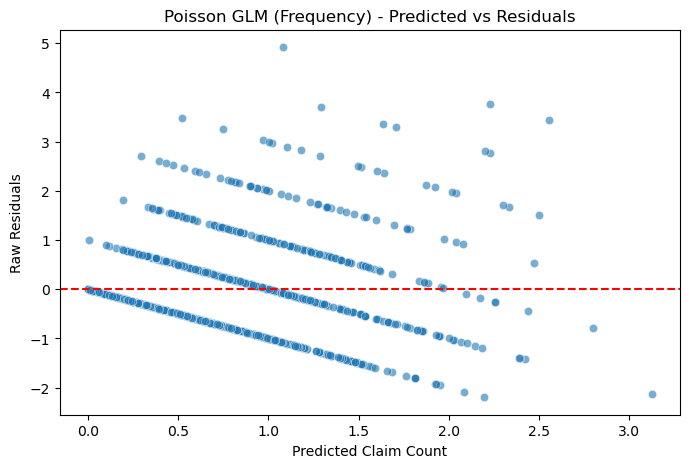

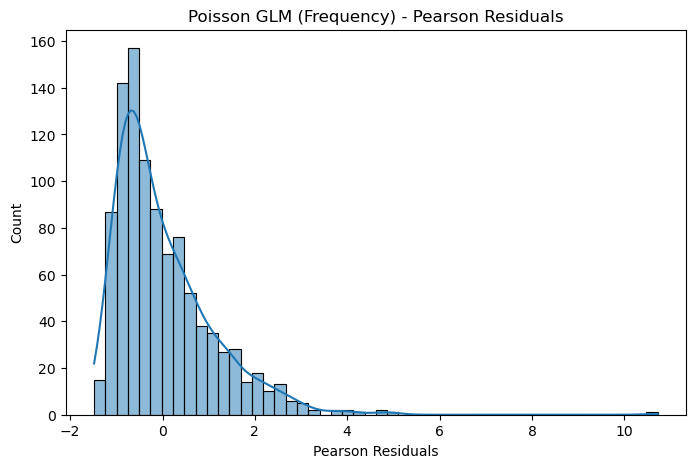

In [8]:



# Predicted vs Raw Residuals
plt.figure(figsize=(8,5))
sns.scatterplot(x='freq_pred', y='freq_resid', data=df, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Claim Count")
plt.ylabel("Raw Residuals")
plt.title("Poisson GLM (Frequency) - Predicted vs Residuals")
plt.show()

# Pearson Residuals Histogram
plt.figure(figsize=(8,5))
sns.histplot(df['freq_pearson'], kde=True)
plt.xlabel("Pearson Residuals")
plt.title("Poisson GLM (Frequency) - Pearson Residuals")
plt.show()


## **Analysis**
### -
#### When looking at our predicted claim count vs raw residual graph, we see what we should expect. The poisson distribution is used for discrete count data such as insurance claims. The data is split into multiple relatively negative linear trends. The bottom trend in the data corresponds to claims counts of zero which can only be overpredicted causing a trend of negative residuals. The next trend above it corresponds to data with 1 claim. This pattern follows throughout the graph. 
#### When looking at pearson residuals, we also see what we would expect. The graph shows a right skew which is typical of frequency insurance data. The graph also shows a centering around zero while the mode is slightly lower than zero.
### -

#### Now we will dive into severity analysis. The code below gives the starting severity formula. Like the frequency diagnostic process, we start with a fairly saturated model. After eliminating various predictors based on criteria of AIC and predictive power, we come to our final severity formula. 
#### We use a Tweedie GLM because of its power with modeling relatively right skewed data. We encorporate a conditional statement below that changes the variance power parameter on .1 increments, which ultimatley settles on the parameter that gives the lowest AIC.  

In [9]:
# Only policies with a claim
claims = df[df["claim_count"] >= 1].copy()
claims['sev'] = claims['claim_amount'] / claims['claim_count']


# formula_sev = """
# sev ~ age + vehicle_age + policy_annual_premium + umbrella_limit +
#        bodily_injuries + number_of_vehicles_involved +
#        C(policy_state) + C(coverage) + C(vehicle_make) + C(vehicle_model) +
#        C(incident_type) + C(incident_severity) + C(collision_type) + C(property_damage) +
#        age:C(vehicle_make) + coverage:C(vehicle_make) + incident_severity:C(vehicle_make)
# """

formula_sev = """
sev ~ age + 
       bodily_injuries + number_of_vehicles_involved +
        C(vehicle_make) + C(vehicle_model) +
        C(collision_type) + 
       age:C(vehicle_make) 
"""


# List of var_power values to try (typical range for insurance severity)
var_powers = np.arange(1.1, 2.0, 0.1)  # Tweedie power between 1 (Poisson) and 2 (Gamma)

best_aic = np.inf
best_var_power = None
best_model = None

for p in var_powers:
    try:
        model = smf.glm(
            formula=formula_sev,
            data=claims,
            family=sm.families.Tweedie(var_power=p, link=sm.families.links.log())
        ).fit()
        
        print(f"Var Power: {p:.2f} | AIC: {model.aic:.2f}")
        
        if model.aic < best_aic:
            best_aic = model.aic
            best_var_power = p
            best_model = model
    except Exception as e:
        print(f"Var Power: {p:.2f} failed with error: {e}")

print("\nBest Tweedie var_power:")
print(f"Var Power: {best_var_power:.2f} | AIC: {best_aic:.2f}")
print(best_model.summary())


/opt/anaconda3/envs/python_course/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/opt/anaconda3/envs/python_course/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/opt/anaconda3/envs/python_course/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/opt/anaconda3/envs/python_course/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/opt/ana

Var Power: 1.10 | AIC: 11796.03
Var Power: 1.20 | AIC: 11653.67
Var Power: 1.30 | AIC: 11618.50
Var Power: 1.40 | AIC: 11598.60
Var Power: 1.50 | AIC: 11583.40
Var Power: 1.60 | AIC: 11572.01
Var Power: 1.70 | AIC: 11564.49
Var Power: 1.80 | AIC: 11561.01


/opt/anaconda3/envs/python_course/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/opt/anaconda3/envs/python_course/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/opt/anaconda3/envs/python_course/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


Var Power: 1.90 | AIC: 11561.79

Best Tweedie var_power:
Var Power: 1.80 | AIC: 11561.01
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    sev   No. Observations:                  526
Model:                            GLM   Df Residuals:                      468
Model Family:                 Tweedie   Df Model:                           57
Link Function:                    log   Scale:                          1.6202
Method:                          IRLS   Log-Likelihood:                -5722.5
Date:                Tue, 02 Dec 2025   Deviance:                       836.55
Time:                        20:52:51   Pearson chi2:                     758.
No. Iterations:                    15   Pseudo R-squ. (CS):             0.9106
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
----------------

### Now we go on to graphing predicted severity vs raw residuals, deviance residual histogram, and predicted vs actual severity

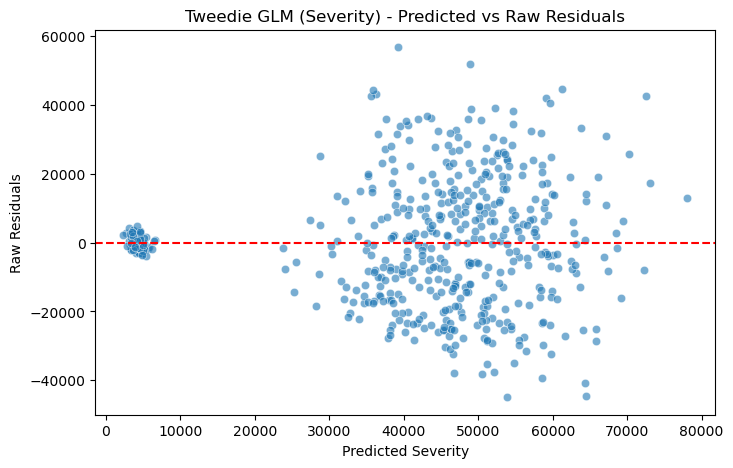

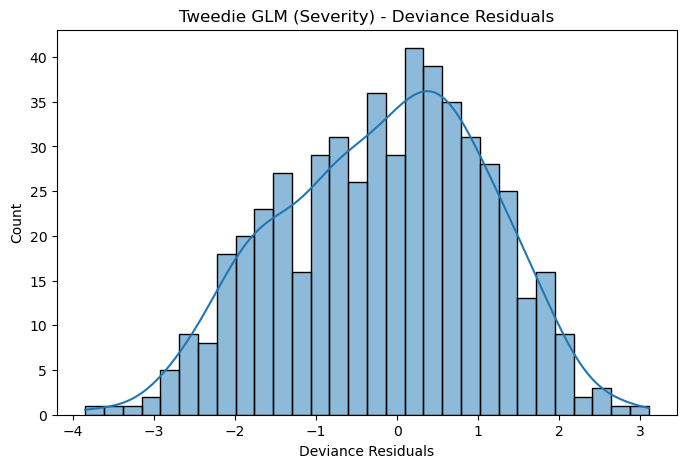

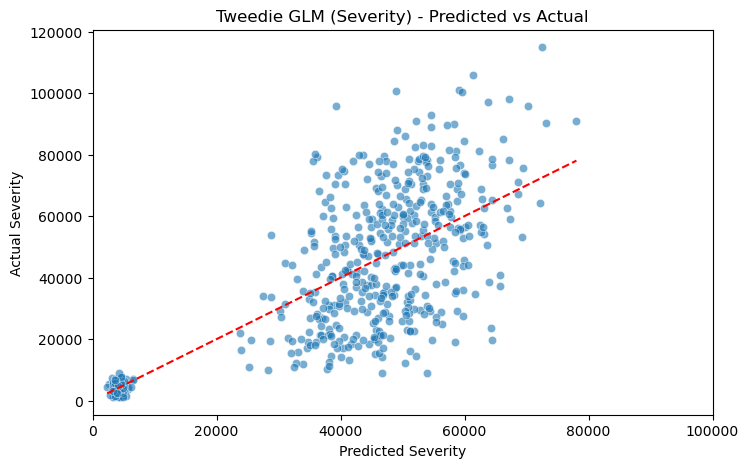

In [10]:
# Predicted values
claims['sev_pred'] = best_model.predict()

# Raw residuals
claims['sev_resid'] = claims['sev'] - claims['sev_pred']

# Deviance residuals
claims['sev_dev_resid'] = best_model.resid_deviance

# ------------------- Plot 1: Predicted vs Raw Residuals -------------------
plt.figure(figsize=(8,5))
sns.scatterplot(x='sev_pred', y='sev_resid', data=claims, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Severity")
plt.ylabel("Raw Residuals")
plt.title("Tweedie GLM (Severity) - Predicted vs Raw Residuals")
plt.show()

# ------------------- Plot 2: Deviance Residuals -------------------
plt.figure(figsize=(8,5))
sns.histplot(claims['sev_dev_resid'], kde=True, bins=30)
plt.xlabel("Deviance Residuals")
plt.title("Tweedie GLM (Severity) - Deviance Residuals")
plt.show()

# ------------------- Plot 3: Predicted vs Actual Severity -------------------
plt.figure(figsize=(8,5))
sns.scatterplot(x='sev_pred', y='sev', data=claims, alpha=0.6)
plt.plot([claims['sev_pred'].min(), claims['sev_pred'].max()],
         [claims['sev_pred'].min(), claims['sev_pred'].max()],
         color='red', linestyle='--')  # 45-degree line
plt.xlabel("Predicted Severity")
plt.ylabel("Actual Severity")
plt.xlim(0,100000)
plt.title("Tweedie GLM (Severity) - Predicted vs Actual")
plt.show()




## **Analysis**
### -
### When looking at a residual plot regarding severity data, we want to see a random spread of residuals. The plot we have shows a small clumping of low residual values for low predicted severity data. This suggests that the model is fairly accurate when modeling this data for low severity data. The vast majority of the data to the right shows a highly random spread of residuals with slight funneling. This funneling reveals minimal heteroscadasticity which is common in insurance data. 
### Our deviance residual chart shows  centering around zero in a normal curve which is what we want in the data.
### The predicted vs actual severity graph shows the same small cluster of low severity predictions that are extremely accurate. Then while looking right, we see that the vast majority of predictions fall between around $30,000 and $65,000. The spread shows a relatively balanced spread between high and low predictions as we saw in the raw residual plot.
### -

### The code below creates 10 decile categories and creates a table showing predictive model effectivness at every decile. 

In [16]:
# Use claims dataset with sev and sev_pred
claims['sev_pred_decile'] = pd.qcut(claims['sev_pred'], 10, labels=False) + 1

decile_summary = claims.groupby('sev_pred_decile').agg(
    n=('sev', 'size'),
    avg_pred=('sev_pred', 'mean'),
    avg_actual=('sev', 'mean'),
    total_pred=('sev_pred', 'sum'),
    total_actual=('sev', 'sum')
).reset_index()

print(decile_summary)

   sev_pred_decile   n      avg_pred    avg_actual    total_pred  total_actual
0                1  53   3783.204533   4139.119497  2.005098e+05  2.193733e+05
1                2  53  11093.228911  10161.993711  5.879411e+05  5.385857e+05
2                3  52  35696.462156  33956.467949  1.856216e+06  1.765736e+06
3                4  53  39775.030100  40532.194969  2.108077e+06  2.148206e+06
4                5  52  43761.709814  43694.070513  2.275609e+06  2.272092e+06
5                6  53  46624.256872  43705.132075  2.471086e+06  2.316372e+06
6                7  52  49656.503262  52163.397436  2.582138e+06  2.712497e+06
7                8  53  52631.160657  54598.867925  2.789452e+06  2.893740e+06
8                9  52  56708.156079  56447.403846  2.948824e+06  2.935265e+06
9               10  53  63823.560552  65157.169811  3.382649e+06  3.453330e+06


### The code below graphs the decile actual and predicted severity. We would want to see that at each decile, the predicted values follow closely to the actual values.

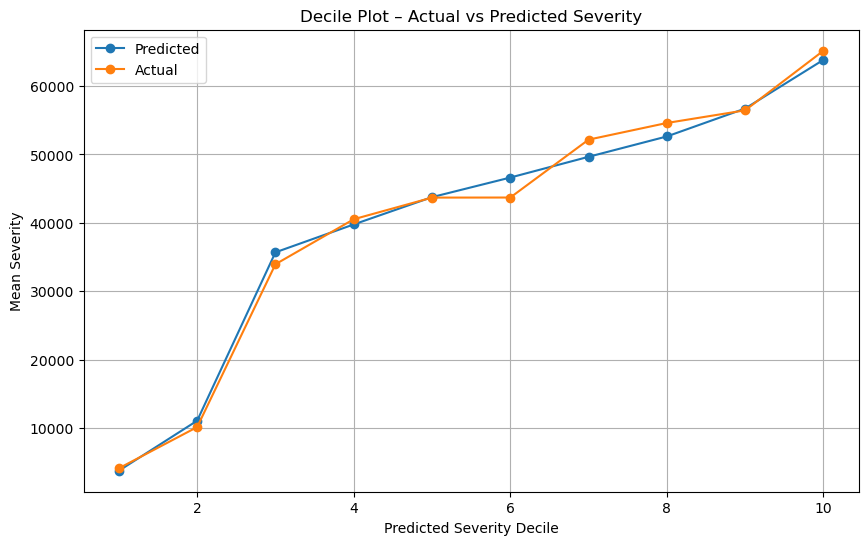

In [12]:
plt.figure(figsize=(10,6))
plt.plot(decile_summary['sev_pred_decile'], decile_summary['avg_pred'], marker='o')
plt.plot(decile_summary['sev_pred_decile'], decile_summary['avg_actual'], marker='o')
plt.xlabel("Predicted Severity Decile")
plt.ylabel("Mean Severity")
plt.title("Decile Plot – Actual vs Predicted Severity")
plt.legend(["Predicted", "Actual"])
plt.grid(True)
plt.show()

### Now we calculate lift which is the actual average data for each decile divided by actual overall mean of the data. We want to see a steady increase in lift as the deciles increase. This will show a relatively strong model.

In [13]:
overall_actual_mean = claims['sev'].mean()

decile_summary['lift'] = decile_summary['avg_actual'] / overall_actual_mean
print(decile_summary[['sev_pred_decile', 'avg_actual', 'lift']])


   sev_pred_decile    avg_actual      lift
0                1   4139.119497  0.102430
1                2  10161.993711  0.251478
2                3  33956.467949  0.840317
3                4  40532.194969  1.003046
4                5  43694.070513  1.081292
5                6  43705.132075  1.081566
6                7  52163.397436  1.290882
7                8  54598.867925  1.351152
8                9  56447.403846  1.396898
9               10  65157.169811  1.612437


/var/folders/lb/wlsk85h52gl2qqmvp2gd7xrw0000gn/T/ipykernel_19942/4266518912.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


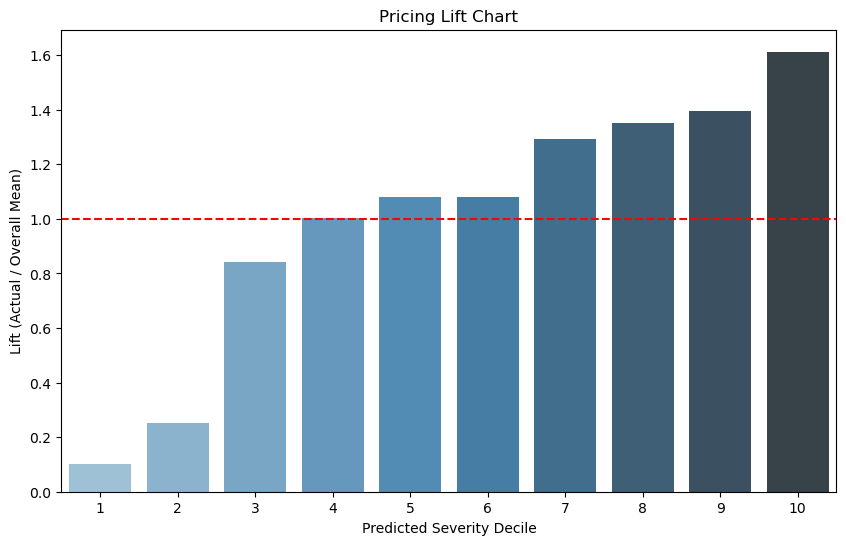

In [14]:
plt.figure(figsize=(10,6))
sns.barplot(
    x=decile_summary['sev_pred_decile'],
    y=decile_summary['lift'],
    palette="Blues_d"
)
plt.axhline(1.0, color='red', linestyle='--')
plt.xlabel("Predicted Severity Decile")
plt.ylabel("Lift (Actual / Overall Mean)")
plt.title("Pricing Lift Chart")
plt.show()


## **Analysis**
### -
#### In the pricing lift chart, we generally see a positive increase of lift at each decile. We see a strong increase from the 2nd to third decile and relatvely small increases thereafter with slighlty larger jumps from sixth to seventh deciles and ninth to tenth deciles. While there are small increases at points, the chart always increases and shows a relatively strong model.
### - 